### CNN-LSTM_v3

- 파이썬 버전: 3.8.18

### 1. Library 불러오기, SEED 설정, CUDA 사용

In [1]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sequence as sq # 사용자 정의 함수 불러오기

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from collections import Counter

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns

# 하이퍼파라미터 튜닝
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit

# 운영체제 관련
import platform

'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)  # 멀티 GPU 사용 시
# GPU에서 실행할 때, CUDNN 자동 튜너의 비결정적 행동을 방지하기 위해 이를 설정
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 운영체제별 device 설정
os_name = platform.system()
if os_name == 'Windows':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"이 PC는 윈도우 운영 체제입니다: {device} is available")
elif os_name == 'Darwin':
    device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
    print(f"이 PC는 맥(OS X) 운영 체제입니다: {device} is available")
else:
    print(f"이 PC는 다른 운영 체제입니다: {os_name}")


이 PC는 윈도우 운영 체제입니다: cuda:0 is available


### 2. 데이터 불러오기 및 전처리 (Binary, Scale, Tensor, train&valid&test split)

In [2]:
import pickle

# 불러오기
file_path = '../../data/'
seq_len = 20

with open(f'{file_path}x_train_seq_{seq_len}.pkl', 'rb') as file:
     X_train_seq= pickle.load(file)

with open(f'{file_path}x_val_seq_{seq_len}.pkl', 'rb') as file:
     X_val_seq= pickle.load(file)

with open(f'{file_path}X_test_seq_{seq_len}.pkl', 'rb') as file:
     X_test_seq= pickle.load(file)

with open(f'{file_path}y_train_seq_{seq_len}.pkl', 'rb') as file:
     y_train_seq= pickle.load(file)

with open(f'{file_path}y_val_seq_{seq_len}.pkl', 'rb') as file:
     y_val_seq= pickle.load(file)

with open(f'{file_path}y_test_seq_{seq_len}.pkl', 'rb') as file:
     y_test_seq= pickle.load(file)

In [3]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
valid = torch.utils.data.TensorDataset(X_val_seq, y_val_seq)
test = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
batch_size = 2048 # 32, 64, 128, 256, 512, 1024, 2048, 2048, 4096, 8192
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


### 3. 모델 정의

In [4]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMModel, self).__init__()
        
        # CNN 레이어
        '''
        in_channels = 일반적인 이미지와 같은 2D 데이터를 다룰 때는 특성 맵(channel)을 채널로 인식함.
        그러나 주식 시계열 데이터와 같은 1D 데이터의 경우 시퀀스 길이에 해당하는 차원이 채널로 간주됨.
        이에 따라 'in_channels'에는 시퀀스 길이를 입력해야 함.
        즉, 주식 시게열 데이터에서는 'in_channels'에는 시퀀스의 길이가 들어가야 올바르게 수행됨.
        '''
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        # LSTM 레이어
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes) # Fully Connected 레이어
        
    def forward(self, x):
        # CNN 레이어 적용 (cnn takes input of shape (batch_size, channels, seq_len))
        x = x.permute(0, 2, 1)
        out = self.cnn(x)
        
        # LSTM 레이어 적용
        '''
        LSTM 레이어에 입력을 전달하고, LSTM의 출력과 은닉 상태를 받는 부분
        x.permute(0, 2, 1): 입력텐서 x의 차원을 변경. 일반적으로 LSTM 레이어는 시간 단계(seq_len)를 두 번쨰 차원으로 받지만,
        Conv1d 레이어의 출력은 시간 단계가 세번째 차원에 위치함. 따라서 permute를 통해 차원을 변경하여 LSTM 레이어에 올바른 형태의 입력을 제공
        여기서 0번째 차원은 배치 크기(batch_size)를 나타내며, 1번째 차원은 특성 수(num_features)를 나타냄. 마지막(2번째) 차원은 시간 단계(seq_len)를 나타냄
        self.lstm(x.permute(0, 2, 1)): 변경된 입력을 LSTM 레이어에 전달함. LSTM 입력으로 3D 텐서를 받으며,
        이 텐서는 배치 크기(batch_size), 시간 단계(seq_len),. 특성 수(num_features)의 형태를 가짐
        lstm_out, _: LSTM 레이어의 출력과 은닉 상태를 받음. 여기서 은닉 상태는 사용하지 않기 때문에 '_'로 무시. lstm_out은 LSTM 레이어의 출력으로, 각 시간 단계에
        해당하는 출력을 포함하는 3D 텐서임.
        '''
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        
        # Fully Connected 레이어에 입력
        '''
        lstm_out[:, -1, :]: LSTM 레이어의 출력에서 마지막 시간 단계의 출력만 선택. 이는 시퀀스 예측을 위해 마지막 시간 단계의 정보만을 사용하고자 하는 것
        따라서 [:, -1, :]는 모든 배치와 모든 특성을 유지하면서 마지막 시간 단계의 출력을 선택함
        self.fc(lstm_out[:, -1, :]): 선택된 마지막 시간 단계의 출력을 Fully Connected(FC) 레이어에 입력함. FC 레이어는 입력된 LSTM 출력을 받아서 최종
        예측을 수행하는 역할을 함. 출력 크기는 1이며, 이는 주어진 입력에 대한 예측된 결과를 나타냄.
        '''
        out = self.fc(out[:, -1, :]) 
        return out

#model = CNNLSTMModel(input_size=77, hidden_size=64, num_layers=2, num_classes=1)
model = CNNLSTMModel(input_size=77, hidden_size=128, num_layers=2, num_classes=1)
model.to(device) # GPU 사용 시

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(77, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

### 4. 모델학습1: train, valid를 이용한 과적합 방지되는 epochs 찾기

In [5]:
# # 학습1: valid를 이용한 과적합 방지 epochs 찾기

# # 학습과 검증 손실을 저장할 리스트 초기화
# train_losses = []
# valid_losses = []

# # # 손실 함수와 옵티마이저 정의
# criterion = nn.BCEWithLogitsLoss() # 시그모이드 활성화 함수가 내장되어 있음. 모델의 마지막 레이어에서 시그모이드 함수 별도 적용할 필요X
# #criterion = nn.BCELoss() # 모델 출력이 시그모이드 활성화 함수를 거쳐 확률로 변환된 후의 값을 입력으로 받음. 입력 값은 0과 1사이의 확률 값.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# num_epochs = 20

# # 검증 데이터에 대한 모델 성능 평가 함수 정의
# def evaluate(model, criterion, dataloader):
#     model.eval()  # 모델을 평가 모드로 설정
#     total_loss = 0.0
    
#     with torch.no_grad():
#         for batch_features, batch_targets in dataloader:
#             # 배치를 GPU로 전송
#             batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            
#             # 모델에 대한 순전파 및 손실 계산
#             outputs = model(batch_features)
#             loss = criterion(outputs, batch_targets)
            
#             total_loss += loss.item()
    
#     return total_loss / len(dataloader.dataset)  # 평균 손실 반환

# # 학습 루프
# for epoch in range(num_epochs):
#     model.train()  # 모델을 학습 모드로 설정
#     total_loss = 0.0
    
#     for batch_features, batch_targets in train_loader:
#         # 배치를 GPU로 전송
#         batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
#         # 모델에 대한 순전파 및 손실 계산
#         optimizer.zero_grad()
#         outputs = model(batch_features)
#         loss = criterion(outputs, batch_targets)
        
#         # 역전파 및 최적화
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     # 에폭마다 학습 손실 기록
#     train_loss = total_loss / len(train_loader.dataset)
#     train_losses.append(train_loss)
    
#     # 검증 데이터에 대한 손실 계산 및 기록
#     valid_loss = evaluate(model, criterion, valid_loader)
#     valid_losses.append(valid_loss)
    
#     # 에폭마다 손실 출력
#     print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.round(train_loss, 7)}, Valid Loss: {np.round(valid_loss, 7)}')

# # 손실 함수 시각화
# plt.plot(train_losses, label='Train Loss')
# plt.plot(valid_losses, label='Valid Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()


### 5. 모델학습2: 모델학습1에서 구한 epochs를 기준으로 train 데이터만 가지고 학습

In [6]:
'''
학습2: train data만 가지고 학습
이미 학습1 코드에서 모델이 학습을 수행하였으므로
학습2 코드 실행 전 재시작 -> 학습1 코드 실행 X -> 학습2 코드 실행(정해진 epochs만 학습)
'''

# 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 11 # train, valid loss를 기준으로 과적합되기 전 epochs

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_features, batch_targets in train_loader:
        # 배치를 GPU로 전송
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        # 모델에 대한 순전파 및 손실 계산
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 에폭마다 손실 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')


Epoch 1/11, Loss: 22.18666297197342
Epoch 2/11, Loss: 20.68582570552826
Epoch 3/11, Loss: 17.52592697739601
Epoch 4/11, Loss: 16.37597644329071
Epoch 5/11, Loss: 15.935973525047302
Epoch 6/11, Loss: 15.635221391916275
Epoch 7/11, Loss: 15.40710437297821
Epoch 8/11, Loss: 15.21940392255783
Epoch 9/11, Loss: 15.060950756072998
Epoch 10/11, Loss: 14.927325636148453
Epoch 11/11, Loss: 14.759337663650513


Data Imbalance: Counter({0.0: 11343, 1.0: 10873})
Accuracy: 0.7758
Precision: 0.7792
Recall: 0.7563
F1 Score: 0.7676


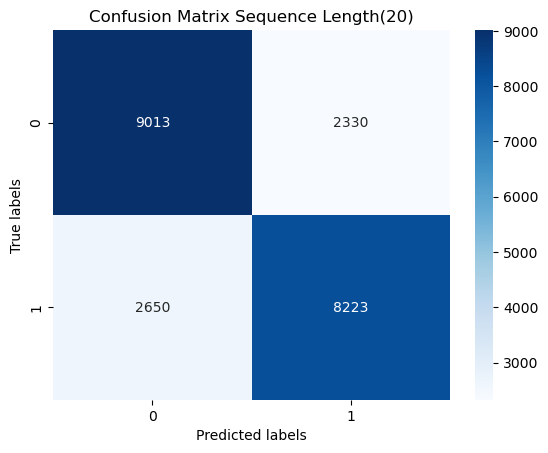

In [7]:
# 테스트 데이터 예측
model.eval()  # 모델을 평가 모드로 설정
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)

        # 로그 오즈를 확률로 변환
        probs = torch.sigmoid(outputs).squeeze()

        # 확률을 기준으로 0.5 이상이면 1, 미만이면 0으로 예측
        preds = torch.round(probs).cpu().numpy()
        y_true.extend(labels.squeeze().cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Data Imbalance: {Counter(y_true)}')
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix Sequence Length({seq_len})')
plt.show()

In [8]:
@@@

SyntaxError: invalid syntax (4226661135.py, line 1)

### 5-2. 백테스트


In [ ]:
true_df = pd.DataFrame(y_test_bt)
true_df.columns=['return', 'true']
pred_df = pd.DataFrame({'pred': y_pred})
bt_df = pd.concat([true_df, pred_df], axis=1)
bt_df

,return,true,pred
0,-0.002043,0.0,0.0
1,-0.001591,0.0,0.0
2,-0.001974,0.0,0.0
3,-0.002844,0.0,0.0
4,-0.002253,0.0,0.0
...,...,...,...
22211,-0.001066,0.0,0.0
22212,-0.000147,0.0,0.0
22213,-0.000049,0.0,0.0
22214,-0.001098,0.0,0.0


In [ ]:
simulated_returns = bt_df[bt_df['pred'] == 1]['return']
total_return = (simulated_returns + 1).prod() # 총 수익: 1 더하고 모든 값 곱하기
# 방법1:
# sum 보다는 그냥 return 값에 1을 더하고, 그 값을 모두 곱하면 수익률
# 곱한 항의 개수대로 루트를 씌운다(투자 횟수)
# 방법2:
# 투자한 10분동안의 거래에는 또 다른 거래가 일어날 수 없다.
# 투자한 10분 이내의 1값은 제거해야 한다.
initial_investment = len(simulated_returns) # 투자 횟수
rooted_returns = np.power(total_return, 1/initial_investment) # 곱한 항의 개수대로 루트 씌우기

print(f"초기 투자 횟수: {initial_investment}")
print(f"총 수익: {total_return.round(4)}")
print(f"수익률: {(rooted_returns * 100).round(4)}%")


초기 투자 횟수: 4413
총 수익: 43.1308
수익률: 100.0853%


In [ ]:
# 순차적으로 'pred' 컬럼에서 1이 나온 이후 10개 행을 삭제하는 함수 개선
def filter_data_sequentially(df, window=10):
    i = 0
    while i < len(df):
        if df.iloc[i]['pred'] == 1:
            # pred가 1인 행을 찾으면, 그 행 포함하여 이후 window 크기만큼의 행을 삭제
            start = i
            df = df.drop(index=df.index[start+1:start+11])
            # 인덱스 리셋 후 다시 순회 시작
            # df = df.reset_index(drop=True)
            i += 1  # 인덱스 초기화
        else:
            i += 1
    return df

# 함수 적용
filtered_bt_df = filter_data_sequentially(bt_df, 10)

filtered_bt_df


,return,true,pred
0,-0.002043,0.0,0.0
1,-0.001591,0.0,0.0
2,-0.001974,0.0,0.0
3,-0.002844,0.0,0.0
4,-0.002253,0.0,0.0
...,...,...,...
22201,-0.000541,0.0,1.0
22212,-0.000147,0.0,0.0
22213,-0.000049,0.0,0.0
22214,-0.001098,0.0,0.0


In [ ]:
# def filter_data_sequentially(df, window=10):
#     i = 0
#     while i < len(df):
#         if df.iloc[i]['pred'] == 1:
#             # pred가 1인 행을 찾으면, 그 행 포함하여 이후 window 크기만큼의 행을 삭제
#             # 데이터프레임의 마지막 부분 처리
#             if i + window > len(df):
#                 df = df.drop(index=df.index[i+1:len(df)])  # 마지막에서 window 미만 남았을 때 나머지 모두 삭제
#                 break  # 모든 삭제 작업이 끝났으므로 반복문 종료
#             else:
#                 df = df.drop(index=df.index[i+1:i+1+window])  # i+1부터 window 개수만큼 삭제
#         i += 1
#     return df#.reset_index(drop=True)


In [ ]:
# 10분 투자기간 준수했을 때의 백테스트
simulated_returns = filtered_bt_df[filtered_bt_df['pred'] == 1]['return']
total_return = (simulated_returns + 1).prod() # 총 수익: 1 더하고 모든 값 곱하기
initial_investment = len(simulated_returns) # 투자 횟수
rooted_returns = np.power(total_return, 1/initial_investment) # 곱한 항의 개수대로 루트 씌우기

print(f"초기 투자 횟수: {initial_investment}")
print(f"총 수익: {total_return.round(4)}")
print(f"수익률: {(rooted_returns * 100).round(4)}%")

초기 투자 횟수: 780
총 수익: 1.3192
수익률: 100.0355%


In [ ]:
filtered_bt_df[filtered_bt_df['pred']==1]

,return,true,pred
26,0.000948,1.0,1.0
64,-0.000756,0.0,1.0
83,-0.002499,0.0,1.0
118,-0.000057,0.0,1.0
129,0.000711,1.0,1.0
...,...,...,...
22059,-0.001000,0.0,1.0
22103,-0.001131,0.0,1.0
22118,-0.001361,0.0,1.0
22164,-0.000147,0.0,1.0
